In [1]:
from nepc.util import config
from nepc.util import util
from nepc.util import parser
import nepc
import numpy as np
import re
import pandas as pd

In [2]:
NEPC_HOME = config.nepc_home()
outdir = NEPC_HOME + "/tests/data/cs/n2/fict_total"

In [3]:
util.rmdir(outdir)
util.mkdir(outdir)

In [4]:
debug = False

In [5]:
if debug:
    next_cs_id, next_csdata_id = (27, 578)
else:
    next_cs_id, next_csdata_id = parser.get_next_ids(test=True)

In [6]:
next_cs_id

28

In [7]:
next_csdata_id

579

In [8]:
pd.set_option('max_colwidth', 100)

In [9]:
cnx, cursor = nepc.connect(local=True, test=True)

In [10]:
def log_interp(zz, xx, yy):
    logz = np.log10(zz)
    logx = np.log10(xx)
    logy = np.log10(yy)
    return np.power(10.0, np.interp(logz, logx, logy, right=-1000.0))

In [11]:
n_fict_excitation_e_j = nepc.CustomModel(cursor, "fict", filter={'process': 'excitation'})

In [12]:
n_fict_excitation_e_j.summary()

Number of cross sections in model: 15


,cs_id,specie,lhsA,rhsA,process,reaction,threshold,E_peak,E_upper,sigma_max,lpu,upu
0,1,N2,N2(X1Sigmag+),N2(X1Sigmag+)_jSCHULZ,excitation,e$^-$ + N${}_2$ (X ${}^1\Sigma_g^+$) $\rightarrow$ N${}_2$ (X ${}^1\Sigma_g^+ j=SCHULZ$) + e$^-$,0.02,2.3,3.6,6.9e-20,-1,-1
1,3,N2,N2(X1Sigmag+),N2(X1Sigmag+)_jSLAR,excitation,e$^-$ + N${}_2$ (X ${}^1\Sigma_g^+$) $\rightarrow$ N${}_2$ (X ${}^1\Sigma_g^+ j=SLAR$) + e$^-$,0.02,2.2,3.6,2.77e-20,-1,-1
2,13,N2,N2(X1Sigmag+),N2(A3Sigmau+)_v0-4,excitation,e$^-$ + N${}_2$ (X ${}^1\Sigma_g^+$) $\rightarrow$ N${}_2$ (A ${}^3\Sigma_u^+ v=(0-4)$) + e$^-$,6.17,16,70,1.5e-22,-1,-1
3,14,N2,N2(X1Sigmag+),N2(A3Sigmau+)_v5-9,excitation,e$^-$ + N${}_2$ (X ${}^1\Sigma_g^+$) $\rightarrow$ N${}_2$ (A ${}^3\Sigma_u^+ v=(5-9)$) + e$^-$,7,16,70,6.5e-22,-1,-1
4,15,N2,N2(X1Sigmag+),N2(B3Pig),excitation,e$^-$ + N${}_2$ (X ${}^1\Sigma_g^+$) $\rightarrow$ N${}_2$ (B ${}^3\Pi_g$) + e$^-$,7.35,12,70,2.003e-21,-1,-1
5,16,N2,N2(X1Sigmag+),N2(W3Deltau),excitation,e$^-$ + N${}_2$ (X ${}^1\Sigma_g^+$) $\rightarrow$ N${}_2$ (W ${}^3\Delta_u$) + e$^-$,7.36,16,100,2.546e-21,-1,-1
6,17,N2,N2(X1Sigmag+),N2(A3Sigmau+)_v10-,excitation,e$^-$ + N${}_2$ (X ${}^1\Sigma_g^+$) $\rightarrow$ N${}_2$ (A ${}^3\Sigma_u^+ v=(10-)$) + e$^-$,7.8,17,70,6.7e-22,-1,-1
7,18,N2,N2(X1Sigmag+),N2(Bp3Sigmau-),excitation,e$^-$ + N${}_2$ (X ${}^1\Sigma_g^+$) $\rightarrow$ N${}_2$ (B${}^{'} $ ${}^3\Sigma_u^-$) + e$^-$,8.16,15,70,8.38e-22,-1,-1
8,19,N2,N2(X1Sigmag+),N2(ap1Sigmau-),excitation,e$^-$ + N${}_2$ (X ${}^1\Sigma_g^+$) $\rightarrow$ N${}_2$ (a${}^{'}$ ${}^1\Sigma_u^-$) + e$^-$,8.4,15,150,6.97e-22,-1,-1
9,20,N2,N2(X1Sigmag+),N2(a1Pig),excitation,e$^-$ + N${}_2$ (X ${}^1\Sigma_g^+$) $\rightarrow$ N${}_2$ (a ${}^1\Pi_g$) + e$^-$,8.55,17,1000,2.023e-21,-1,-1


In [13]:
n_fict_excitation_e = n_fict_excitation_e_j.cs[2:]

In [14]:
for cs in n_fict_excitation_e:
    print('cs_id: {}'.format(cs.metadata['cs_id']))

cs_id: 13
cs_id: 14
cs_id: 15
cs_id: 16
cs_id: 17
cs_id: 18
cs_id: 19
cs_id: 20
cs_id: 21
cs_id: 22
cs_id: 23
cs_id: 24
cs_id: 25


In [15]:
n_fict_excitation_j = n_fict_excitation_e_j.cs[1]

In [16]:
n_fict_excitation_j.metadata['cs_id']

3

In [17]:
n_fict_excitation_v = nepc.CustomModel(cursor, "fict", filter={'process': 'excitation_v'})

In [18]:
n_fict_excitation_v.summary()

Number of cross sections in model: 9


,cs_id,specie,lhsA,rhsA,process,reaction,threshold,E_peak,E_upper,sigma_max,lpu,upu
0,4,N2,N2(X1Sigmag+),N2(X1Sigmag+),excitation_v,e$^-$ + N${}_2$ (X ${}^1\Sigma_g^+$ v=0) $\rightarrow$ N${}_2$ (X ${}^1\Sigma_g^+$ v=1) + e$^-$,0.29,1.6,50,1.5e-21,-1,-1
1,5,N2,N2(X1Sigmag+),N2(X1Sigmag+),excitation_v,e$^-$ + N${}_2$ (X ${}^1\Sigma_g^+$ v=0) $\rightarrow$ N${}_2$ (X ${}^1\Sigma_g^+$ v=1) + e$^-$,0.291,2,3.6,4.8e-20,-1,-1
2,6,N2,N2(X1Sigmag+),N2(X1Sigmag+),excitation_v,e$^-$ + N${}_2$ (X ${}^1\Sigma_g^+$ v=0) $\rightarrow$ N${}_2$ (X ${}^1\Sigma_g^+$ v=2) + e$^-$,0.59,2.1,3.5,3.3e-20,-1,-1
3,7,N2,N2(X1Sigmag+),N2(X1Sigmag+),excitation_v,e$^-$ + N${}_2$ (X ${}^1\Sigma_g^+$ v=0) $\rightarrow$ N${}_2$ (X ${}^1\Sigma_g^+$ v=3) + e$^-$,0.88,2.2,3.3,2.7e-20,-1,-1
4,8,N2,N2(X1Sigmag+),N2(X1Sigmag+),excitation_v,e$^-$ + N${}_2$ (X ${}^1\Sigma_g^+$ v=0) $\rightarrow$ N${}_2$ (X ${}^1\Sigma_g^+$ v=4) + e$^-$,1.17,2.3,3.2,2.385e-20,-1,-1
5,9,N2,N2(X1Sigmag+),N2(X1Sigmag+),excitation_v,e$^-$ + N${}_2$ (X ${}^1\Sigma_g^+$ v=0) $\rightarrow$ N${}_2$ (X ${}^1\Sigma_g^+$ v=5) + e$^-$,1.47,2.4,3.3,1.53e-20,-1,-1
6,10,N2,N2(X1Sigmag+),N2(X1Sigmag+),excitation_v,e$^-$ + N${}_2$ (X ${}^1\Sigma_g^+$ v=0) $\rightarrow$ N${}_2$ (X ${}^1\Sigma_g^+$ v=6) + e$^-$,1.76,2.5,3.1,1.74e-20,-1,-1
7,11,N2,N2(X1Sigmag+),N2(X1Sigmag+),excitation_v,e$^-$ + N${}_2$ (X ${}^1\Sigma_g^+$ v=0) $\rightarrow$ N${}_2$ (X ${}^1\Sigma_g^+$ v=7) + e$^-$,2.06,2.7,3.4,9.6e-21,-1,-1
8,12,N2,N2(X1Sigmag+),N2(X1Sigmag+),excitation_v,e$^-$ + N${}_2$ (X ${}^1\Sigma_g^+$ v=0) $\rightarrow$ N${}_2$ (X ${}^1\Sigma_g^+$ v=8) + e$^-$,2.35,2.7,3.4,3.6e-21,-1,-1


In [19]:
n_fict_excitation_e_v_j = nepc.CustomModel(cs_list = [n_fict_excitation_j] + n_fict_excitation_e + n_fict_excitation_v.cs)

In [20]:
n_fict_excitation_e_v_j.summary()

Number of cross sections in model: 23


,cs_id,specie,lhsA,rhsA,process,reaction,threshold,E_peak,E_upper,sigma_max,lpu,upu
0,3,N2,N2(X1Sigmag+),N2(X1Sigmag+)_jSLAR,excitation,e$^-$ + N${}_2$ (X ${}^1\Sigma_g^+$) $\rightarrow$ N${}_2$ (X ${}^1\Sigma_g^+ j=SLAR$) + e$^-$,0.02,2.2,3.6,2.77e-20,-1,-1
1,13,N2,N2(X1Sigmag+),N2(A3Sigmau+)_v0-4,excitation,e$^-$ + N${}_2$ (X ${}^1\Sigma_g^+$) $\rightarrow$ N${}_2$ (A ${}^3\Sigma_u^+ v=(0-4)$) + e$^-$,6.17,16,70,1.5e-22,-1,-1
2,14,N2,N2(X1Sigmag+),N2(A3Sigmau+)_v5-9,excitation,e$^-$ + N${}_2$ (X ${}^1\Sigma_g^+$) $\rightarrow$ N${}_2$ (A ${}^3\Sigma_u^+ v=(5-9)$) + e$^-$,7,16,70,6.5e-22,-1,-1
3,15,N2,N2(X1Sigmag+),N2(B3Pig),excitation,e$^-$ + N${}_2$ (X ${}^1\Sigma_g^+$) $\rightarrow$ N${}_2$ (B ${}^3\Pi_g$) + e$^-$,7.35,12,70,2.003e-21,-1,-1
4,16,N2,N2(X1Sigmag+),N2(W3Deltau),excitation,e$^-$ + N${}_2$ (X ${}^1\Sigma_g^+$) $\rightarrow$ N${}_2$ (W ${}^3\Delta_u$) + e$^-$,7.36,16,100,2.546e-21,-1,-1
5,17,N2,N2(X1Sigmag+),N2(A3Sigmau+)_v10-,excitation,e$^-$ + N${}_2$ (X ${}^1\Sigma_g^+$) $\rightarrow$ N${}_2$ (A ${}^3\Sigma_u^+ v=(10-)$) + e$^-$,7.8,17,70,6.7e-22,-1,-1
6,18,N2,N2(X1Sigmag+),N2(Bp3Sigmau-),excitation,e$^-$ + N${}_2$ (X ${}^1\Sigma_g^+$) $\rightarrow$ N${}_2$ (B${}^{'} $ ${}^3\Sigma_u^-$) + e$^-$,8.16,15,70,8.38e-22,-1,-1
7,19,N2,N2(X1Sigmag+),N2(ap1Sigmau-),excitation,e$^-$ + N${}_2$ (X ${}^1\Sigma_g^+$) $\rightarrow$ N${}_2$ (a${}^{'}$ ${}^1\Sigma_u^-$) + e$^-$,8.4,15,150,6.97e-22,-1,-1
8,20,N2,N2(X1Sigmag+),N2(a1Pig),excitation,e$^-$ + N${}_2$ (X ${}^1\Sigma_g^+$) $\rightarrow$ N${}_2$ (a ${}^1\Pi_g$) + e$^-$,8.55,17,1000,2.023e-21,-1,-1
9,21,N2,N2(X1Sigmag+),N2(w1Deltau),excitation,e$^-$ + N${}_2$ (X ${}^1\Sigma_g^+$) $\rightarrow$ N${}_2$ (w ${}^1\Delta_u$) + e$^-$,8.89,13,50,7.84e-22,-1,-1


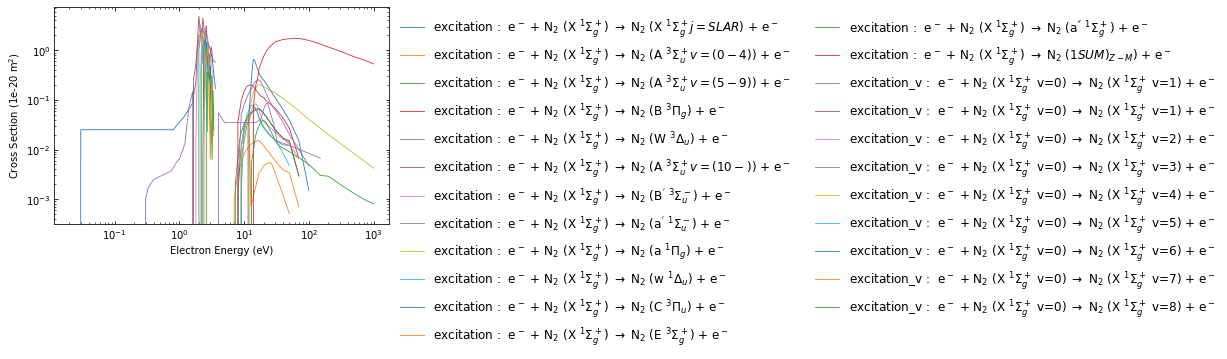

In [21]:
n_fict_excitation_e_v_j.plot(units_sigma=1E-20,
              plot_param_dict = {'linewidth':.8}, 
              #xlim_param_dict = {'left': 1, 'right': 120.0}, 
              ylog=True, xlog=True, max_plots=40, width=14, height=14)

In [22]:
e_range = np.logspace(-2, 3, 501)

In [23]:
sigma = [0.0 for _ in range(len(e_range))]
for e, i in zip(e_range, range(len(e_range))):    
    for cs in n_fict_excitation_e_v_j.cs:
        sigma_i = log_interp(e, cs.data['e'], cs.data['sigma'])
        if ~np.isnan(sigma_i):
            sigma[i] += sigma_i
sigma_nan = np.isnan(sigma)
sigma = np.array(sigma)
e_range = e_range[~sigma_nan]
sigma = sigma[~sigma_nan]
eps = 1E-24
sigma[np.abs(sigma) < eps] = 0.0

/usr/local/anaconda3/envs/nepc/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


In [24]:
fict_min_excitation_total = nepc.CustomCS(metadata={'specie': 'N2',
                                                     'process': 'excitation_total',
                                                     'units_e': 1.0,
                                                     'units_sigma': 1.0,
                                                     'ref': '\\N',
                                                     'lhsA': 'N2(X1Sigmag+)',
                                                     'lhsB': None,
                                                     'rhsA': 'N2*',
                                                     'rhsB': None,
                                                     'threshold': 0.02,
                                                     'wavelength': -1.0,
                                                     'lhs_v': -1,
                                                     'rhs_v': -1,
                                                     'lhs_j': -1,
                                                     'rhs_j': -1,
                                                     'background': 'Sum of excitations (electronic, vibrational, and rotational) in fict complete model.',
                                                     'lpu': -1.0,
                                                     'upu': -1.0,
                                                     'lhsA_long': 'N${}_2$ (X ${}^1\\Sigma_g^+$)',
                                                     'lhsB_long': None,
                                                     'rhsA_long': 'N${}_2^*$',
                                                     'rhsB_long': None,
                                                     'e_on_lhs': 1,
                                                     'e_on_rhs': 1,
                                                     'hv_on_lhs': 0,
                                                     'hv_on_rhs': 0,
                                                     'v_on_lhs': 0,
                                                     'v_on_rhs': 0,
                                                     'j_on_lhs': 0,
                                                     'j_on_rhs': 0},
                                            data={'e': list(e_range),
                                                  'sigma': list(sigma)})

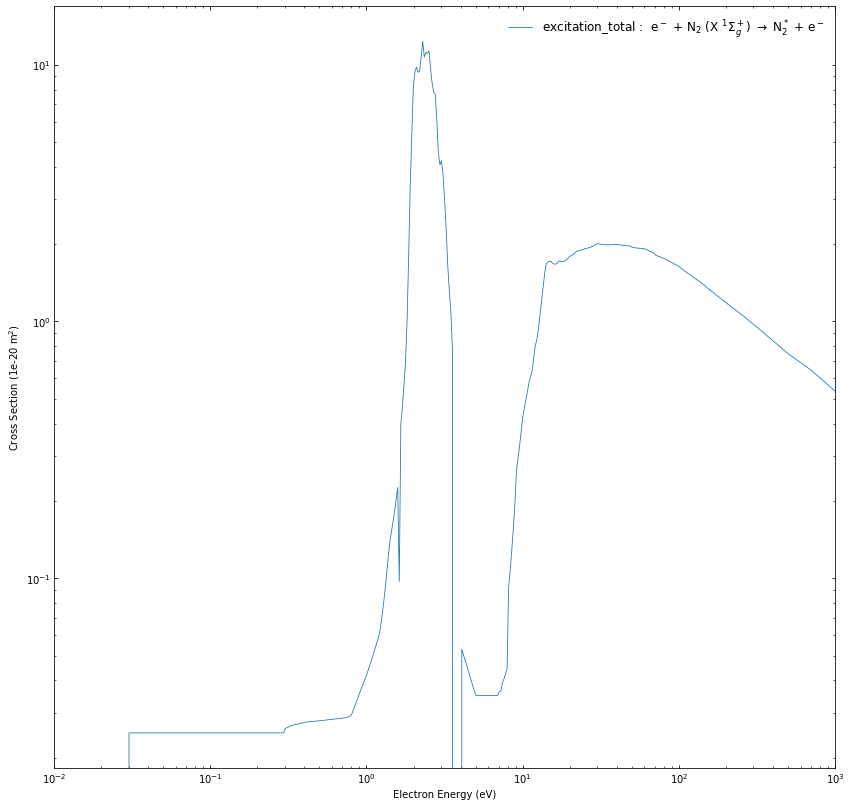

In [25]:
fict_min_excitation_total.plot(units_sigma=1E-20,
              plot_param_dict = {'linewidth':.8}, 
              xlim_param_dict = {'left': .01, 'right': 1000.0}, 
              ylog=True, xlog=True, width=4, height=4)

In [26]:
n_fict_excitation_e_v_j_total = nepc.CustomModel(
    cs_list=([n_fict_excitation_j] + n_fict_excitation_e + 
             n_fict_excitation_v.cs + [fict_min_excitation_total]))

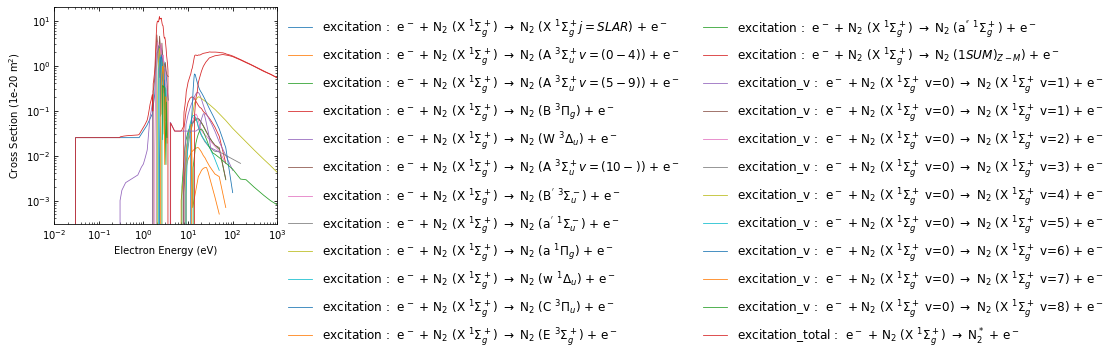

In [27]:
n_fict_excitation_e_v_j_total.plot(units_sigma=1E-20,
                                     plot_param_dict = {'linewidth':.8}, 
                                     xlim_param_dict = {'left': .01, 'right': 1000.0}, 
                                     ylog=True, xlog=True, max_plots=40, width=8, height=8)

In [28]:
data_array = np.asarray([[e_i, sigma_i] for e_i, sigma_i in zip(fict_min_excitation_total.data['e'],
                                                                fict_min_excitation_total.data['sigma'])])

In [29]:
cs_name = outdir + '/fict_min_excitation_total'
next_csdata_id = parser.write_data_to_file(data_array=data_array,
                                            filename=cs_name+'.dat',
                                            start_csdata_id=next_csdata_id)
next_cs_id = parser.write_metadata_to_file(filename=cs_name+'.met',
                                            cs_id=next_cs_id,
                                            specie=fict_min_excitation_total.metadata['specie'],
                                            process=fict_min_excitation_total.metadata['process'],
                                            lhs_a=fict_min_excitation_total.metadata['lhsA'],
                                            rhs_a=fict_min_excitation_total.metadata['rhsA'],
                                            lhs_v=fict_min_excitation_total.metadata['lhs_v'],
                                            rhs_v=fict_min_excitation_total.metadata['rhs_v'],
                                            units_e=fict_min_excitation_total.metadata['units_e'],
                                            units_sigma=fict_min_excitation_total.metadata['units_sigma'],
                                            threshold=fict_min_excitation_total.metadata['threshold'],
                                            ref=fict_min_excitation_total.metadata['ref'],
                                            background=fict_min_excitation_total.metadata['background'])
parser.write_models_to_file(filename=cs_name+'.mod',
                             models_array=['fict', 'fict_min'])

In [30]:
e_range = np.logspace(0, 3, 301)

In [31]:
sigma = [0.0 for _ in range(len(e_range))]
for e, i in zip(e_range, range(len(e_range))):    
    for cs in n_fict_excitation_e:
        sigma_i = log_interp(e, cs.data['e'], cs.data['sigma'])
        if ~np.isnan(sigma_i):
            sigma[i] += sigma_i
sigma_nan = np.isnan(sigma)
sigma = np.array(sigma)
e_range = e_range[~sigma_nan]
sigma = sigma[~sigma_nan]
eps = 1E-24
sigma[np.abs(sigma) < eps] = 0.0

/usr/local/anaconda3/envs/nepc/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


In [32]:
fict_min2_excitation_total_e = nepc.CustomCS(metadata={'specie': 'N2',
                                                     'process': 'excitation_total',
                                                     'units_e': 1.0,
                                                     'units_sigma': 1.0,
                                                     'ref': '\\N',
                                                     'lhsA': 'N2(X1Sigmag+)',
                                                     'lhsB': None,
                                                     'rhsA': 'N2*',
                                                     'rhsB': None,
                                                     'threshold': 6.17,
                                                     'wavelength': -1.0,
                                                     'lhs_v': -1,
                                                     'rhs_v': -1,
                                                     'lhs_j': -1,
                                                     'rhs_j': -1,
                                                     'background': 'Sum of electronic excitations in fict complete model.',
                                                     'lpu': -1.0,
                                                     'upu': -1.0,
                                                     'lhsA_long': 'N${}_2$ (X ${}^1\\Sigma_g^+$)',
                                                     'lhsB_long': None,
                                                     'rhsA_long': 'N${}_2^*$',
                                                     'rhsB_long': None,
                                                     'e_on_lhs': 1,
                                                     'e_on_rhs': 1,
                                                     'hv_on_lhs': 0,
                                                     'hv_on_rhs': 0,
                                                     'v_on_lhs': 0,
                                                     'v_on_rhs': 0,
                                                     'j_on_lhs': 0,
                                                     'j_on_rhs': 0},
                                            data={'e': list(e_range),
                                                  'sigma': list(sigma)})

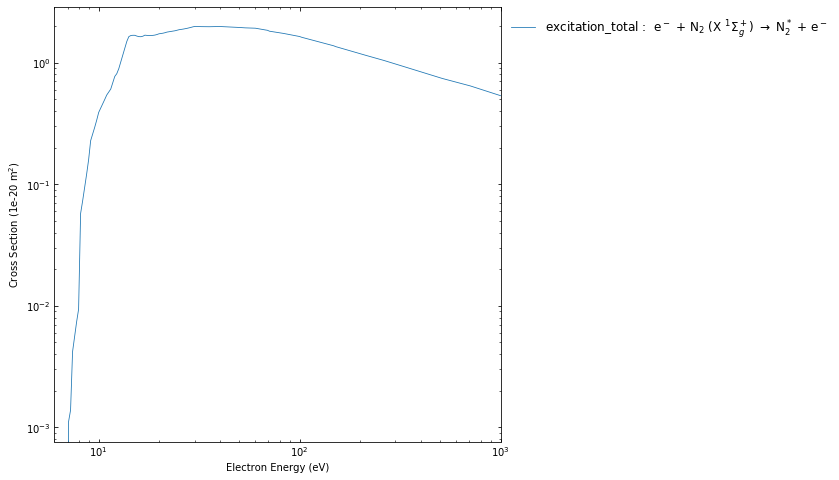

In [33]:
fict_min2_excitation_total_e.plot(units_sigma=1E-20,
              plot_param_dict = {'linewidth':.8}, 
              xlim_param_dict = {'left': 6, 'right': 1000.0}, 
              ylog=True, xlog=True, width=4, height=4)

In [34]:
n_fict_min2_excitation_total_e_model = nepc.CustomModel(
    cs_list=(n_fict_excitation_e + [fict_min2_excitation_total_e]))

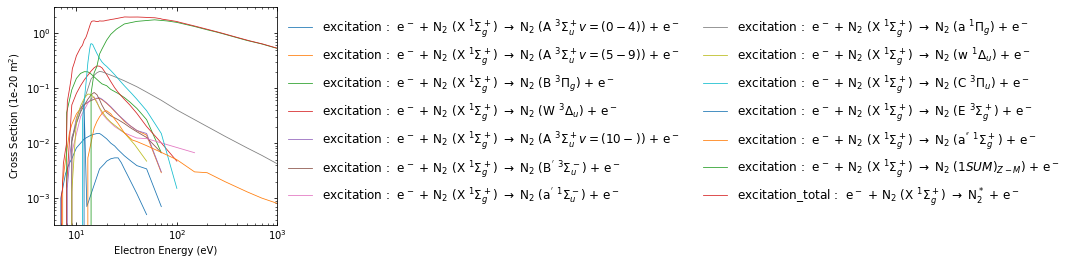

In [35]:
n_fict_min2_excitation_total_e_model.plot(units_sigma=1E-20,
                                     plot_param_dict = {'linewidth':.8}, 
                                     xlim_param_dict = {'left': 6, 'right': 1000.0}, 
                                     ylog=True, xlog=True, max_plots=40, width=12, height=12)

In [36]:
data_array = np.asarray([[e_i, sigma_i] for e_i, sigma_i in zip(fict_min2_excitation_total_e.data['e'],
                                                                fict_min2_excitation_total_e.data['sigma'])])

In [37]:
cs_name = outdir + '/fict_min2_excitation_total_e'
next_csdata_id = parser.write_data_to_file(data_array=data_array,
                                            filename=cs_name+'.dat',
                                            start_csdata_id=next_csdata_id)
next_cs_id = parser.write_metadata_to_file(filename=cs_name+'.met',
                                            cs_id=next_cs_id,
                                            specie=fict_min2_excitation_total_e.metadata['specie'],
                                            process=fict_min2_excitation_total_e.metadata['process'],
                                            lhs_a=fict_min2_excitation_total_e.metadata['lhsA'],
                                            rhs_a=fict_min2_excitation_total_e.metadata['rhsA'],
                                            lhs_v=fict_min2_excitation_total_e.metadata['lhs_v'],
                                            rhs_v=fict_min2_excitation_total_e.metadata['rhs_v'],
                                            units_e=fict_min2_excitation_total_e.metadata['units_e'],
                                            units_sigma=fict_min2_excitation_total_e.metadata['units_sigma'],
                                            threshold=fict_min2_excitation_total_e.metadata['threshold'],
                                            ref=fict_min2_excitation_total_e.metadata['ref'],
                                            background=fict_min2_excitation_total_e.metadata['background'])
parser.write_models_to_file(filename=cs_name+'.mod',
                             models_array=['fict', 'fict_min2'])

In [38]:
e_range = np.logspace(-1, 2, 301)

In [39]:
sigma = [0.0 for _ in range(len(e_range))]
for e, i in zip(e_range, range(len(e_range))):    
    for cs in n_fict_excitation_v.cs:
        sigma_i = log_interp(e, cs.data['e'], cs.data['sigma'])
        if ~np.isnan(sigma_i):
            sigma[i] += sigma_i
sigma_nan = np.isnan(sigma)
sigma = np.array(sigma)
e_range = e_range[~sigma_nan]
sigma = sigma[~sigma_nan]
eps = 1E-24
sigma[np.abs(sigma) < eps] = 0.0

/usr/local/anaconda3/envs/nepc/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


In [40]:
fict_min2_excitation_total_v = nepc.CustomCS(metadata={'specie': 'N2',
                                                     'process': 'excitation_total',
                                                     'units_e': 1.0,
                                                     'units_sigma': 1.0,
                                                     'ref': '\\N',
                                                     'lhsA': 'N2(X1Sigmag+)',
                                                     'lhsB': None,
                                                     'rhsA': 'N2(X1Sigmag+)_v1-8)',
                                                     'rhsB': None,
                                                     'threshold': 0.29,
                                                     'wavelength': -1.0,
                                                     'lhs_v': -1,
                                                     'rhs_v': -1,
                                                     'lhs_j': -1,
                                                     'rhs_j': -1,
                                                     'background': 'Sum of vibrational excitations for N2(X) state in fict complete model.',
                                                     'lpu': -1.0,
                                                     'upu': -1.0,
                                                     'lhsA_long': 'N${}_2$ (X ${}^1\\Sigma_g^+$)',
                                                     'lhsB_long': None,
                                                     'rhsA_long': 'N${}_2$ (X ${}^1\Sigma_g^+ v=(1-8)$)',
                                                     'rhsB_long': None,
                                                     'e_on_lhs': 1,
                                                     'e_on_rhs': 1,
                                                     'hv_on_lhs': 0,
                                                     'hv_on_rhs': 0,
                                                     'v_on_lhs': 0,
                                                     'v_on_rhs': 0,
                                                     'j_on_lhs': 0,
                                                     'j_on_rhs': 0},
                                            data={'e': list(e_range),
                                                  'sigma': list(sigma)})

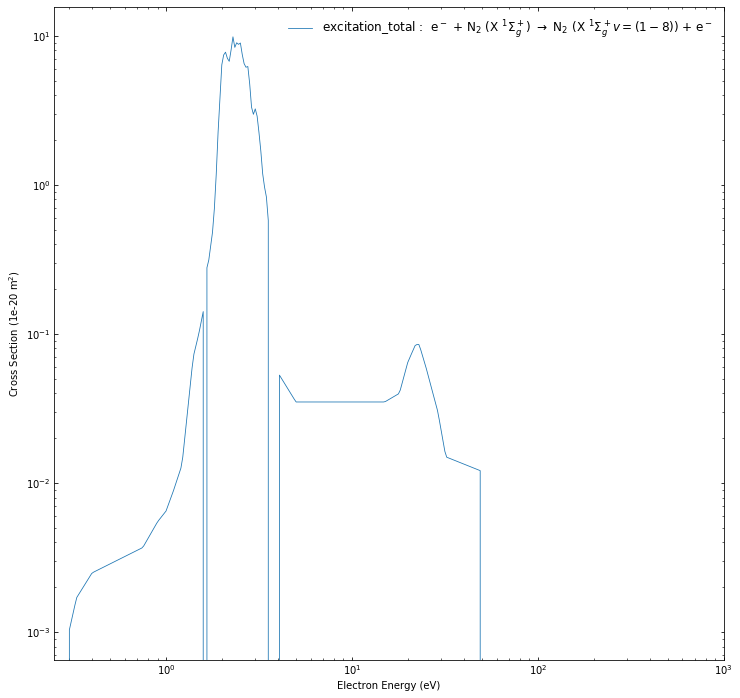

In [41]:
fict_min2_excitation_total_v.plot(units_sigma=1E-20,
              plot_param_dict = {'linewidth':.8}, 
              xlim_param_dict = {'left': 0.25, 'right': 1000.0}, 
              ylog=True, xlog=True, width=4, height=4)

In [42]:
n_fict_min2_excitation_total_v_model = nepc.CustomModel(
    cs_list=(n_fict_excitation_v.cs + [fict_min2_excitation_total_v]))

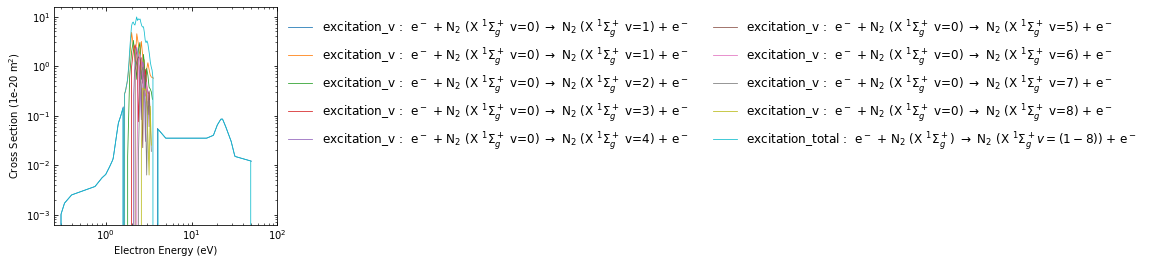

In [43]:
n_fict_min2_excitation_total_v_model.plot(units_sigma=1E-20,
                                     plot_param_dict = {'linewidth':.8}, 
                                     xlim_param_dict = {'left': .25, 'right': 100.0}, 
                                     ylog=True, xlog=True, max_plots=40, width=12, height=12)

In [44]:
data_array = np.asarray([[e_i, sigma_i] for e_i, sigma_i in zip(fict_min2_excitation_total_v.data['e'],
                                                                fict_min2_excitation_total_v.data['sigma'])])

In [45]:
cs_name = outdir + '/fict_min2_excitation_total_v'
next_csdata_id = parser.write_data_to_file(data_array=data_array,
                                            filename=cs_name+'.dat',
                                            start_csdata_id=next_csdata_id)
next_cs_id = parser.write_metadata_to_file(filename=cs_name+'.met',
                                            cs_id=next_cs_id,
                                            specie=fict_min2_excitation_total_v.metadata['specie'],
                                            process=fict_min2_excitation_total_v.metadata['process'],
                                            lhs_a=fict_min2_excitation_total_v.metadata['lhsA'],
                                            rhs_a=fict_min2_excitation_total_v.metadata['rhsA'],
                                            lhs_v=fict_min2_excitation_total_v.metadata['lhs_v'],
                                            rhs_v=fict_min2_excitation_total_v.metadata['rhs_v'],
                                            units_e=fict_min2_excitation_total_v.metadata['units_e'],
                                            units_sigma=fict_min2_excitation_total_v.metadata['units_sigma'],
                                            threshold=fict_min2_excitation_total_v.metadata['threshold'],
                                            ref=fict_min2_excitation_total_v.metadata['ref'],
                                            background=fict_min2_excitation_total_v.metadata['background'])
parser.write_models_to_file(filename=cs_name+'.mod',
                             models_array=['fict', 'fict_min2'])

In [46]:
parser.write_next_id_to_file(next_cs_id, next_csdata_id, test=True)

In [47]:
next_cs_id, next_csdata_id

(31, 1682)

In [48]:
cnx.close()